In [ ]:
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import random

kernel_a = kernel_b = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6

In [ ]:
from scipy import ndimage

def gs(ma, mb, mc, la, lb, lc, da, db, dc, dt, parms):
    F, K = parms
    ndimage.convolve(ma, kernel_a, output=la, mode='wrap')
    ndimage.convolve(mb, kernel_b, output=lb, mode='wrap')
    na = ma + (- ma * mb * mb + F * (1 - ma) + da * la) * dt
    nb = mb + (  ma * mb * mb - (F + K) * mb + db * lb) * dt
    ma[:] = na
    mb[:] = nb


In [ ]:
# generic: generic reaction-diffusion simulation - v6.5.1

class Bunch(dict):
    def __init__(self, dictionary):
        dict.__init__(self, dictionary)
        self.__dict__.update(dictionary)

def generic(diff_a=5, diff_b=1, diff_c=0, delta_t=0.01, start=0, stop=1000, use_a=False, use_b=False, use_c=False,
            seed=1, ini_a=4, ini_b=4, ini_c=0, var_a=0, var_b=1, var_c=0, shape=40,
            axis=False, cmap='inferno', first=False, info=False, limit=None, show='a', size=2, snap=4,
            detail=None, extent=(0, 10), func=None, out=None, dpi=75, interpolation='bilinear',
            detect=False, model=None, parms=None):

    # simulation init

    global sim, a, b, c
    np.random.seed(seed)
    if type(shape) == int: shape = (shape, shape)
    if not use_a:
        a = np.full(shape, ini_a, dtype=float)
        if var_a != 0: a += np.random.random_sample(shape) * var_a
    if not use_b:
        b = np.full(shape, ini_b, dtype=float)
        if var_b != 0: b += np.random.random_sample(shape) * var_b
    if not use_c:
        c = np.full(shape, ini_c, dtype=float)
        if var_c != 0: c += np.random.random_sample(shape) * var_c
    lap_a = np.empty_like(a)
    lap_b = np.empty_like(b)
    lap_c = np.empty_like(c)
    is_last = is_nan = is_stable = is_uniform = last_a = False
    if info:
        high_a = high_b = high_c = - float('inf')
        low_a = low_b = low_c = float('inf')
        if info is True: info = 100
    if detect is True: detect = 100

    # plotting helper functions

    def draw(matrix, row):
        if axis: axes[row, col].axis('on')
        axes[row, col].imshow(matrix, cmap=cmap, interpolation=interpolation)
        axes[row, col].set_anchor('N')
        if limit:
            axes[row, col].set_xbound(0, limit[1] - 1)
            axes[row, col].set_ybound(0, limit[0] - 1)

    def plot():
        axes[0, col].set_title(iteration)
        row = 0
        sa = -1 if '-a' in show else 1
        sb = -1 if '-b' in show else 1
        sc = -1 if '-c' in show else 1
        if detail:
            if 'a' in show:
                t = a.copy()
                t[detail - 1,:] = t[detail + 1,:] = a.min()
                draw(sa * t, row); row += 1
            if 'b' in show:
                t = b.copy()
                t[detail - 1,:] = t[detail + 1,:] = b.min()
                draw(sb * t, row); row += 1
            if 'c' in show:
                t = c.copy()
                t[detail - 1,:] = t[detail + 1,:] = c.min()
                draw(sc * t, row); row += 1
        else:
            if 'a' in show: draw(sa * a, row); row += 1
            if 'b' in show: draw(sb * b, row); row += 1
            if 'c' in show: draw(sc * c, row); row += 1

        if detail:
            axes[row, col].axis('on')
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].grid()
            axes[row, col].plot(a[detail], color='orange')
            axes[row, col].plot(b[detail], color='blue')
            axes[row, col].plot(c[detail], color='black')
            axes[row, col].set_anchor('N')
            axes[row, col].set_ybound(extent[0], extent[1])

    # plotting init

    axes = ax = ay = col = fig = rows = 0
    if 'a' in show: rows += 1
    if 'b' in show: rows += 1
    if 'c' in show: rows += 1
    if detail: rows += 1
    if type(snap) == int:
        if snap > 100: print("too many captures, check 'snap' parameter"); return
        if first: snap = np.linspace(start, stop, snap, dtype=int)
        else: snap = np.linspace(start, stop, snap + 1, dtype=int)[1:]
    cols = len(snap)
    if show:
        fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * size, rows * size), dpi=dpi)
        for ay in axes:
            for ax in ay: ax.axis('off')
    if first and show:
        iteration = start
        plot()
        col += 1
    if type(limit) == int: limit = (limit, limit)

    # simulation loop

    for iteration in range(start + 1, stop + 1):
        if func: is_last = func(iteration, seed)

        if detect and iteration % detect == 0: last_a = a.copy()
        if a.shape != shape:
            shape = a.shape
            lap_a = np.empty_like(a)
            lap_b = np.empty_like(b)
            lap_c = np.empty_like(c)

        model(a, b, c, lap_a, lap_b, lap_c, diff_a, diff_b, diff_c, delta_t, parms)

        if info and iteration % info == 0:
            high_a = max(a.max(), high_a)
            high_b = max(b.max(), high_b)
            high_c = max(c.max(), high_c)
            low_a = min(a.min(), low_a)
            low_b = min(b.min(), low_b)
            low_c = min(c.min(), low_c)
        if detect and iteration % detect == 0:
            if np.ptp(a) < 0.001 or np.ptp(b) < 0.001: is_uniform = True
            elif np.isnan(np.sum(a)): is_nan = True
            elif type(last_a) != bool and np.allclose(a, last_a, atol=0.00001, rtol=0): is_stable = True
            last_a = a.copy()

        if is_last or is_stable or iteration in snap:
            if show: plot()
            col += 1
        if is_last or is_stable or is_uniform or is_nan: break

    # finalization

    if info:
        min_a, max_a, min_b, max_b, min_c, max_c = a.min(), a.max(), b.min(), b.max(), c.min(), c.max()
        print('A [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_a, max_a, low_a, high_a),
              'B [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_b, max_b, low_b, high_b),
              'C [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_c, max_c, low_c, high_c), end='  ')
        if is_last: print('stopped at {}'.format(iteration))
        elif is_nan: print('NaN found in A at {}'.format(iteration))
        elif is_stable: print('stability of A at {}'.format(iteration))
        elif is_uniform: print('uniformity of A or B at {}'.format(iteration))
        else: print()

    if show:
        if col == 0: plt.close()
        else:
            plt.show()
            if out: fig.savefig(out, bbox_inches='tight', dpi=dpi)

    del axes, ax, ay, col, cols, draw, fig, last_a, lap_a, lap_b, lap_c, plot, rows
    sim = Bunch(locals())

In [ ]:
# dynamic figure shortcuts - v1.3

def P(a=False, title='', size=2, axis=False, cmap='inferno', interpolation='bilinear', bins=False, fontsize=12, dpi=75):
    global FIG
    if 'FIG' not in globals():
        # first subplot
        FIG = plt.figure(figsize=(size, size), dpi=dpi)
        ax = FIG.add_subplot(1, 1, 1)
    else:
        # change the geometry and add a new subplot
        n = len(FIG.axes)
        FIG.set_figwidth(FIG.get_figheight() * (n + 1))
        gs = FIG.add_gridspec(1, n + 1)
        for i in range(n):
            FIG.axes[i].set_subplotspec(gs[i])
        ax = FIG.add_subplot(gs[-1])

    ax.axis(axis)
    if title: ax.set_title(title)
    if type(a) == bool: pass
    elif type(a) == np.ndarray and bins != False:
        ax.hist(a.ravel(), bins=bins)
        ax.set_aspect(np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0])
    elif type(a) == np.ndarray and a.ndim == 2: ax.imshow(a, cmap=cmap, interpolation=interpolation)
    elif type(a) == np.ndarray and a.ndim == 3: ax.imshow(a, interpolation=interpolation)
    elif type(a) == str: ax.text(0, 0, a, fontsize=fontsize, fontfamily='monospace')
    else: ax.plot(a)

def S():
    global FIG
    if 'FIG' in globals(): plt.show(); del FIG

def V(*args, **kwargs):
    P(*args, **kwargs); S()

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/tcc/dataset_2'
os.makedirs(path, exist_ok=True)

MessageError: Error: credential propagation was unsuccessful

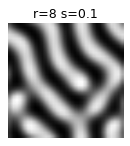

In [ ]:
ratio = 8
scale = 0.10

generic(model=gs, diff_a=ratio * scale, diff_b=scale, delta_t=0.1, parms=(0.100, 0.0540),ini_a=0.2, ini_b=0.5, var_b=0.4, shape=32, stop=10000, snap=1, show='', detect=True)

P(b, title=f"r={ratio} s={scale}", size=2, interpolation='bilinear', cmap='gray')
S()

In [ ]:
for ratio in [5, 6, 7, 8, 10, 12, 15]:
    for scale in [0.05, 0.10, 0.15]:
        for f in [0.100]: #0.04, 0.06, 0.08, 0.10]:
            for k in [0.0540]: #0.050, 0.055, 0.060]:
                for seed in range(0, 120):

                    generic(model=gs, diff_a=ratio * scale, diff_b=scale, delta_t=0.1,
                            parms=(f, k),
                            seed=seed, ini_a=0.2, ini_b=0.5, var_b=0.4,
                            shape=32, stop=10000, snap=1, show='', detect=True)

                    P(b, 'r={} s={}'.format(ratio, scale), size=2, interpolation='bilinear', cmap='gray')

                    #name = f'gs_r{ratio:02d}_s{scale:4.2f}_n{seed:04d}_f{f:4.2f}_k{k:4.2f}.png'
                    name = f'gs_r{ratio:02d}_s{scale:4.2f}_n{seed:04d}.png'
                    #print(name)
                    #plt.imsave(name, b, cmap='gray')
                    #full_path_to_save = os.path.join(path, name)
                    #plt.imsave(full_path_to_save, b, cmap='gray')
